## Imports

In [5]:
import sys
import os
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
from sklearn.linear_model import LinearRegression,Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import importlib

#add path to script
sys.path.append(os.path.abspath("../src/data/"))
sys.path.append(os.path.abspath("../src/model/"))
sys.path.append(os.path.abspath("../src/plots_helper/"))

%matplotlib inline

## 0. Data Cleaning

This first part of the notebook shows all the data cleaning steps. It has to be run once to obtain the cleaned data.

### 0.1 Movie Data

For our analysis, we will need 2 movie datasets: CMU Movies Dataset & Kaggle Movies Dataset. \
\
<b>Why 2 datasets ?</b> \
\
For our purpose, we need movie data and corresponding movie plots (CMU movie metadata & CMU plot summaries respectively). We will then restrict the analysis to American movies, leaving us with approximately half of the original dataset — 20,788 movies. \
Since our aim is to assess the correlation of the data with historical events, the release date is really important. We want to have the precise date, not just the year. However, dropping all rows where the date is not precise will cause us to lose a lot of data, as only 13,335 movies have precise dates. This is where the Kaggle dataset comes in. When the date is not precise, we will try to match the movie with the corresponding from this dataset and extract its date. Using this method, we recover a lot of data and end up with 17,077 movies.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load CMU, plots and Kaggle datasets </li>
    <li>CMU data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Check for NaN values in plots</li>
        <li>Merge CMU metadata and plots on Wikipedia ID — take only movies present in both</li>
        <li>Convert plots to lowercase</li>
        <li>Put each column of the movie metadata in the wanted format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
    </ul>
    <li>Kaggle data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
        <li>Drop NaN values and duplicated rows (if present)</li>
    </ul>
    <li>For incomplete or missing dates, merge with the Kaggle dataset using the movie title, and ultimately the date</li>
    <li>Check for outliers (e.g., incorrect dates)</li>
    <li>Save the cleaned dataset</li>
</ul>

In [6]:
#import the DataLoader class
from src.data.data_loading import DataLoader

raw = 'data/RAW/'
clean = 'data/CLEAN'

In [7]:
# Loader (see data_loading.py for the code regarding this function)
data_loader = DataLoader(raw,clean)
# Load raw data
CMU_movie_metadata, CMU_plot_summary, GVD_data, Kaggle_movies_metadata = data_loader.load_all_data()


load CMU movie metadata


load plot data


load GVD data


load kaggle movie data



#### 0.1.1 CMU metadata

In [8]:
# Let's have a look at the raw CMU metadata first
CMU_movie_metadata

,Freebase movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [9]:
# We will also have a look at the raw CMU plot summaries
CMU_plot_summary

,Plot
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [10]:
# Drop unnecessary columns in metadata
CMU_movie_metadata.drop(['Freebase movie ID', 'Runtime'], axis=1,inplace=True)

In [11]:
# Check for NAN in the plots
CMU_plot_summary[CMU_plot_summary["Plot"].isna()]

,Plot
Wikipedia movie ID,


In [12]:
# Merge the two datasets
Movie_Data = CMU_movie_metadata.merge(CMU_plot_summary,left_index=True, right_index=True, how='inner')

In [13]:
# Lower case the plot_summaries
Movie_Data['Plot'] = Movie_Data['Plot'].str.lower()

In [14]:
# Convert genres, countries and languages in an understandable format
def extract_data(text):
    # Look for all names using a regex pattern: it matches quoted text appearing after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

for name in ['Genres','Countries','Languages'] :
    Movie_Data[name] = Movie_Data[name].apply(extract_data)

In [15]:
# Look for where our movies come from
Movie_Data["Countries"].value_counts() 

Countries
United States of America                                        17774
India                                                            4628
                                                                 3312
United Kingdom                                                   2284
Japan                                                            1157
                                                                ...  
France, Austria, Iraq, Iran                                         1
United States of America, Serbia, Germany                           1
South Africa, Ireland, United Kingdom                               1
France, Australia, United Kingdom, Germany                          1
Yugoslavia, Socialist Federal Republic of Yugoslavia, Serbia        1
Name: count, Length: 1501, dtype: int64

Regarding the countries: we conclude that the majority of CMU movies comes from the US. Hence, we will restrict our analysis to the real world violence in the US, to then correlate it to the movies produced in this country in a relative period of time. Our plan is to investigate both the influence in movie violence on real world crimes and the influence of major violents events in history on "on screen" violence. 

In [16]:
# Keep only American movies
Movie_Data = Movie_Data[Movie_Data['Countries'].str.contains("United States of America", na=False)]

In [17]:
# Look at the shape before any drop for dates
Movie_Data.shape

(20788, 7)

In [18]:
# Find all movies where the date format is incomplete
Movie_Data_date_wrong = Movie_Data[~Movie_Data['Release date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

In [19]:
# Number of remaining datapoints if we drop all rows where the date format is incomplete
Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]

13335

Uhm, not that many movies are left. Thus, let's turn to the Kaggle dataset to solve this issue. 

#### 0.1.2 Kaggle metadata

In [20]:
# Let's have a look at the data
Kaggle_movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [21]:
# Keep only the rows of interest
Kaggle_movies_metadata = Kaggle_movies_metadata[["production_countries","release_date","title"]]

In [22]:
# Check again the countries of production (spoiler: it's again the US)
Kaggle_movies_metadata['production_countries'].value_counts()

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                    17851
[]                                                                                                                                             6282
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                               2238
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                       1654
[{'iso_3166_1': 'JP', 'name': 'Japan'}]                                                                                                        1356
                                                                                                                                              ...  
[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {

In [23]:
# Extract country of production for the Kaggle dataset
def extract_country(text):
    final_countries = ""
    countries = ast.literal_eval(Kaggle_movies_metadata.production_countries[0])
    for country in countries :
        final_countries = final_countries + " " + country['name']
    return final_countries 

Kaggle_movies_metadata.loc[:, 'production_countries'] = Kaggle_movies_metadata['production_countries'].apply(extract_country)

In [24]:
# Keep only American movies
Kaggle_movies_metadata = Kaggle_movies_metadata[Kaggle_movies_metadata['production_countries'].str.contains("United States of America", na=False)]
Kaggle_movies_metadata.shape

(45466, 3)

In [25]:
# Drop NAN values
Kaggle_movies_metadata.dropna(inplace=True)
Kaggle_movies_metadata.shape

(45376, 3)

In [26]:
# Drop full duplicates
Kaggle_movies_metadata.drop_duplicates()
Kaggle_movies_metadata.shape

(45376, 3)

#### 0.1.3 Now that we have our two datasets, we can handle the date & duplicates problems

In [27]:
# An example
Movie_Data[Movie_Data["Movie name"] == "Dr. Jekyll and Mr. Hyde"]

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,NaN,English Language,United States of America,"Short Film, Science Fiction, Horror, Black-and...","dr. henry jekyll sends a note to his fiancée,..."
7883633,Dr. Jekyll and Mr. Hyde,1920-04,NaN,"Silent film, English Language",United States of America,"Silent film, Horror, Indie, Science Fiction, B...",at the first transformation starts with jekyll...
144774,Dr. Jekyll and Mr. Hyde,1931-12-31,NaN,English Language,United States of America,"Science Fiction, Horror, Black-and-white, Dram...","the film tells the story of dr. henry jekyll ,..."
3672796,Dr. Jekyll and Mr. Hyde,1920-03-18,NaN,"Silent film, English Language",United States of America,"Crime Fiction, Silent film, Horror, Science Fi...","henry jekyll is a doctor of medicine, but he ..."
2490751,Dr. Jekyll and Mr. Hyde,1941-08-12,1279000.0,English Language,United States of America,"Science Fiction, Horror, Black-and-white",dr. jekyll believes good and evil exist in ev...
7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,NaN,Silent film,United States of America,"Short Film, Silent film, Horror, Indie, Black-...",dr. jekyll and mr. hyde began with the raising...
7856323,Dr. Jekyll and Mr. Hyde,1912-01-16,NaN,English Language,United States of America,"Short Film, Horror, Black-and-white",james cruze's white-haired dr. jekyll has secr...


In [28]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == "Dr. Jekyll and Mr. Hyde"]

,production_countries,release_date,title
7055,United States of America,1941-08-12,Dr. Jekyll and Mr. Hyde
7823,United States of America,1931-12-31,Dr. Jekyll and Mr. Hyde
8294,United States of America,1920-03-18,Dr. Jekyll and Mr. Hyde
25134,United States of America,2008-05-17,Dr. Jekyll and Mr. Hyde


As we can see, some names are similar in both datasets, but there is no duplicate. They are different movies. \
We will take that into account for the date algorithm. 

In [29]:
# Iter on all rows of the wrong date dataset
for index, row in Movie_Data_date_wrong.iterrows() :
    # Is it in the Kaggle dataset ?
    kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
    # If not, drop the row
    if kaggle_data.empty :
        #print("drop")
        Movie_Data.drop([index], inplace=True)

    # If yes and only one, extract the date
    elif kaggle_data.shape[0] == 1 :
        #print("change")
        Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

    # If multiple movies have this name in the Kaggle dataset, compare with the incomplete date of the CMU dataset
    else :
        date = Movie_Data_date_wrong.loc[index, "Release date"]

        # If not the same year and not the year in the CMU, drop
        if pd.isna(date) or len(date) < 4 :
            Movie_Data.drop([index],inplace=True)

        # Else, compare
        else :
            kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]

            # Found only 1 movie this year ? extract the date !
            if kaggle_data.shape[0] == 1 :
                #print("found!")
                Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

            # Give up
            else :
                #print("sad..")
                Movie_Data.drop([index], inplace=True)

In [30]:
Movie_Data 
# Nice we kept 4000 more data !

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
21926710,White on Rice,2009-05-31,NaN,,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...
25011340,Dot.Kill,2005-03-08,NaN,,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...


In [31]:
# We are thus left with:
print("We are thus left with: {} movies.".format(len(Movie_Data)))

We are thus left with: 17077 movies.


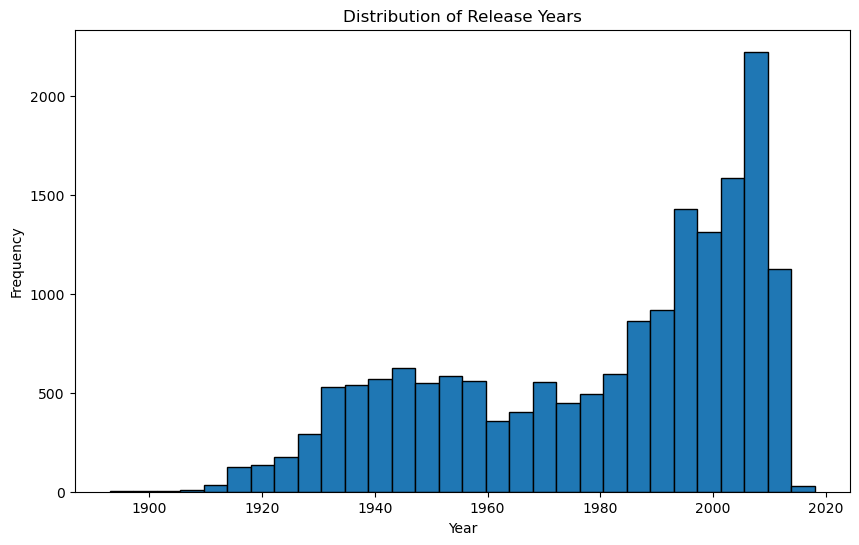

In [32]:
Date = Movie_Data["Release date"].str[:4].astype(int)
plt.figure(figsize=(10, 6))
plt.hist(Date, bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Looks nice ! no outliers :)

In [37]:
# Save the data 
Movie_Data.to_csv(clean+"/Movie_Data_clean.tsv", sep="\t")

### 0.2 Real World Violence Dataset

To be able to build analysis on real-violence we need additional data. We chose to keep two datasets that complement each other : GVD and NIBRS. The first provides an overview of violent deaths per year from 2004 to 2021, while the latter gives much more granular information. The aim is to pinpoint interesting set of years to dweleve in with NIBRS dataset, while having an overview thanks to GVD one. 


1.⁠ ⁠**GVD, Global Violent Deaths :** Aggregates violent deaths annually.
    -Source : https://www.smallarmssurvey.org/database/global-violent-deaths-gvd
   - Description : Aggregated and validated data on violent deaths per country and per year with additional information such as sex and indicator (eg. intentional homicide). 

*Data preprocessing step for GVD*: 
We will apply the following pipeline:
<ul>
<li>Load GVD entire dataset</li>
<li>Filter and keep only USA related data </li>
<li>Remove all unecessary columns (eg. country_name)</li> 
<li>Remove uninentional homicide since we are interested only in violent interactions that are intentional </li>
</ul>
    
2.⁠ **NIBRS, National Incident-Based Reporting System :** Offers daily-level crime data 
   -Source: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads
   -Description : Reported crimes to the FBI per state and per year with detailed information such as victims related ones, crime and so on. 
   - NIBRS data offers more precise informations about daily crimes as it provides the precise date of an incident. 
   - Each incident can easily be classified in order to keep only violent crimes.
   - To go further, NIBRS can provide victim's injury, incident circumstances and if weapons were used during the incident.
  
*Data preprocessing step for NIBRS*
We have applied the following step in order to have well-formated and useful data:
<ul>
<li>For each state all the yearly data need to be downloaded and stored with the following protocol: 
  

Name_of_the_state folder\
├── XX-year1\
├── XX-year2\
├── XX-year3\
...
</li>

<li>⁠Iteration on each XX-year folder in order to modify in lowercase all the name and label of each file.</li>
<li>⁠Merging of useful parameters:<ul>
<li>incident_id ⁠: unique identifier of each incident</li>
<li>incident_date ⁠: precise date of the incident</li>
<li>offense_type_id ⁠: type of offense of the incident</li>
<li>Help to get ⁠ offense_name ⁠ (e.g., Assault Offenses, Homicide Offenses)</li>
<li>Help to get ⁠ crime_against ⁠ (e.g., Society, Person)</li>
<li>arrestee_id ⁠: identifier of the arrestee</li>
<li>weapon_id ⁠: identifier of the weapon used (if one was used)</li>
<li>victim_id ⁠: identifier of the victim</li>
<li>injury_id ⁠: identifier of victim injury</li>
<li>circumstances_id ⁠: identifier of circumstances related to the incident</li>
    </ul></li>
<li>Data cleaning:⁠<ul>
  <li> Keep only incidents with violent ⁠ offense_name⁠</li>
  <li> Keep only incidents with ⁠ crime_against ⁠ = Person</li></ul></li>
<li>Save the cleaned dataset</li>
<ul>

#### 0.2.1 FBI NIBRS database

You'll find the entire database [here](https://www.dolthub.com/repositories/Liquidata/fbi-nibrs/data/main) to help to visualize the entire data.

The downloaded data comes from the [**FBI Crime Data Explorer**](https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads).


In [36]:
#import relative script 
import src.data.FBI_cleaning
import src.data.FBI_merging
#import src.data.FBI_analysis

from src.data.FBI_preprocess_folder import preprocess_files_in_directory
from src.data.FBI_merging import process_state_data,merge_offense_types
#from FBI_analysis import analyze_incidents_and_missing_values,analyze_offenses
from src.data.FBI_cleaning import filter_violent_offenses

ImportError: cannot import name 'merge_offense_types' from 'src.data.FBI_merging' (/home/jen/Documents/EPFL/ADA/ada-2024-project-alligatorsdontapologize24/src/data/FBI_merging.py)

##### 0.2.1.1 load and merge the data (Alabama, as a first example)

In order to have all reported incidents for a given state, we have the merge multiple datafiles. 

**Preprocessing**

It is needed to do a preprocessing on each state folder in order to have only lowercase in the folder and label name. The function `preprocess_files_in_directory()` directly modify the folder name and labels in each file.

In [ ]:
# Define the base directory where Alabama data is stored
state_dir = raw +'/Alabama'

# Run the function to preprocess all files in the Alabama directory
preprocess_files_in_directory(state_dir)

**Merging interesting data**

In [ ]:
# Define the output file
output_file = os.path.join(state_dir, 'Alabama_merged_data.csv')

# Process data for the state and save it
final_data = process_state_data(state_dir, output_file)


In [ ]:
final_data

**Let's visualize the data**

In [ ]:
importlib.reload(FBI_analysis)

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(final_data, 'incident_date', verbose=False)

**Analysis Summary**
From the bar plots, we observe the following:

1. **Data concentration in 1991 and 1992:**
   - The majority of the data is concentrated in the years 1991 and 1992, with very limited data for other years. This may limit the temporal analysis but provides a strong starting point for studying patterns in these two years.
   - Further investigation across other states might help fill in data gaps for a more comprehensive view.
2. **Missing `incident_date` values:**
   - A few `incident_date` values are missing, specifically 14280. Despite these missing dates, the remaining data is largely complete.
3. **Availability of `offense_type_id`:**
    - All offense types are available, which is good for categorizing offenses based on our criteria for violence. This will help us to classify offenses and filter incidents related to violent behavior.
4. **Missing Data for Specific Parameters:**
    - Four key columns (`arrestee_id`, `weapon_id`, `injury_id`, and `circumstances_id`) show a significant number of missing values, as indicated in the NaN count plot.
    - We hope additional data from other states can fill in some of these gaps. However, since offense types are available, we can still proceed with classification based on offenses alone.
5. **Insights on Weapons and Injuries:**
    - The weapon_id and injury_id columns, though missing some values, provide information on the type and severity of violence. While this missing data presents some limitations, the existing offense data could compensate.

So, despite some missing values in specific columns, the precise date of the incident, the available offense data and partial details on weapons and injuries can provide a solid foundation for analyzing violent incidents. We can refine our approach further as more data becomes available from additional states.

In [ ]:
# Define the base directory where Alabama data is stored
base_dir = '../../data/RAW/Alabama'
state_prefix = 'AL'

# Analyze and visualize the offenses
analyze_offenses(final_data, base_dir, state_prefix, verbose=False)

**Analysis of Offense Types**

From the bar plots, we can say:

1. **Unique offense types in `State_merged_data`:**
    - The first plot shows the number of unique offense types present in the `State_merged_data`, in our example Alabama. We observe that a subset of approximately 45 unique offenses is available in the data.
    - This means that the majority of incidents fall into well-defined and recurring offense categories. It will help us to categorize incidents reliably based on these established classifications.
2. **Top 10 Most Frequent Offense Types:**
    - The second plot displays the top 10 most frequently cited offense types in the dataset, along with their occurrence counts. Offenses like *Burglary/Breaking & Entering*, *All Other Larceny*, and *Simple Assault* are the most common.
    - These recurring offenses serve as strong indicators for our analysis, particularly for categorizing incidents as violent or non-violent.
  
In summary, the offenses available in the NIBRS data for Alabama are not only varied but also recurrent, which provides a reliable basis for violent incident classification. The top 10 offenses illustrate the primary incident types and should help us for further analysis focused on identifying patterns of violent behavior.

##### 0.2.1.2 Clean the data (the case of Washington)

After loading and merging the data for one state, we need to clean the data. We will use the case of the state of Washington

In [ ]:
# Load the washington data
WA_data_example = pd.read_csv(raw+"/Washington/Washington_merged_data.csv", index_col=0)
WA_data_example

In order to clean the data, we will use data that gives `offense_type`. To do so, we have to iterate through the years to get all offense types. We save the results in `offense_data`

In [ ]:
importlib.reload(FBI_merging)

offense_data = merge_offense_types(raw +'/Washington', 'WA')

To clean a state data (in our example Washington), we have to keep only violent incidents. As a proof of concept, we will only focus on 2 parameters used in `offense_data`:
-  crime against a `Person`
-  violent categories found in `offense_category_name`

In [ ]:
# Visualize offense_data
offense_data

In [ ]:
# Example of violent categories and targets used in filter_violent_offenses
# violent_categories = [
#         "Assault Offenses", "Homicide Offenses", "Sex Offenses", "Kidnapping/Abduction", "Animal Cruelty"]
#     violent_targets = ["Person"]  # Offenses against a person

# Clean the data by filtering out non-violent offenses
WA_cleaned_data = filter_violent_offenses(WA_data_example, offense_data)

# Save the cleaned data
state_clean_dir = clean
output_file = os.path.join(state_clean_dir, 'Washington_cleaned_data.csv')

WA_cleaned_data.to_csv(output_file, index=False)

In [ ]:
WA_cleaned_data

**Comparison before/after cleaning**

In [ ]:
importlib.reload(FBI_analysis)

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_data_example, 'incident_date', verbose=False)

In [ ]:
# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_cleaned_data, 'incident_date', verbose=False)

In [ ]:
# Define the base directory where Alabama data is stored
base_dir = raw +'/Washington'
state_prefix = 'WA'

# Analyze and visualize the offenses
analyze_offenses(WA_cleaned_data, base_dir, state_prefix, verbose=False)

The first plot shows that the majority of incidents fall into well-defined and recurring offense categories. It will help us to categorize incidents reliably based on these established classifications

The second plot shows that the top 10 most reccurent violent offense.

#### 0.2.2 GVD dataset

In [ ]:
# Load the GVD dataset
GVD_data = pd.read_csv(raw+'GVD_Dataset/2023_gvdDatabase_1_0_country.csv')

# Select only american data 
GVD_usa = GVD_data[GVD_data['country_code'] == 'USA']

In [ ]:
# Remove the columns that are no longer needed
columns_to_remove = ["country_code","country_name","country_region", "country_subregion"]
GVD_usa = GVD_usa.drop(columns=columns_to_remove)
GVD_usa_voluntary = GVD_usa[GVD_usa.indicator != "Homicide unintentional"]
#GVD_usa_voluntary.to_csv(clean+"GVD_clean.csv")

In [ ]:
# Create different dataframe for each population to analyse potential biais in the data
GVD_usa =GVD_data[GVD_data.country_code == "USA"]
GVD_female = GVD_usa[GVD_usa.population == "Female"]
GVD_male = GVD_usa[GVD_usa.population == "Male"]
GVD_all = GVD_usa[GVD_usa.population == "Total"]

In [ ]:
GVD_all_homicide =GVD_all[(GVD_all.mechanism== "All") & (GVD_all.indicator == "Homicide intentional")]
GVD_all_violent_death =GVD_all[(GVD_all.mechanism== "All") & (GVD_all.indicator == "Violent death")]

# Plot the number of inentional homicides and violent per year in the USA
fig, axes = plt.subplots(1,2,figsize=(18, 5),sharey=True)
sns.barplot(ax=axes[0], x="year", y="count",hue="year", data=GVD_all_homicide)
axes[0].set_title("Intentional Homicides in the USA")
axes[0].set_xlabel("Year")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel("Number of deaths per category")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(ax=axes[1], x="year", y="count",hue="year", data=GVD_all_violent_death)
axes[1].set_title("Violent Deaths in the USA")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_xlabel("Year")
axes[1].legend("")

plt.tight_layout()

We are surprised by the higher number of violent deaths compared to intentional homicide. This will require further investigation. 

Note that entry comment enable to have any idea of the reliability of the data. The following comments were points that we wished to investigate further : 

'Data interpolated using a linear approximation in the 2023 update.',
'Data estimated using a global multiplier in the 2023 update.',
'Data estimated using a subregional average in the 2023 update.',
'Data estimated in the 2023 update.'

### 0.3 Human labelled data

For your project, we needed to assign to each movie a violence level. We therefore performed a human-labelling steps to create a training/validation set. This data also need to be cleaned.

<b> First step: labelling the Data </b> \
Since labeled data is required for analysis, we manually labeled a subset of the dataset. We divided part of the data among team members and, to ensure the subjectivity of the labeling process, we had some plots labeled multiple times by external participants. Each movie plot was classified based on a categorical scale:
<ul>
    <li><b>-1</b> : Peaceful</li>
    <li><b>0</b> : Mild</li>
    <li><b>1</b> : Violent</li>
</ul>

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load The data</li>
    <li>Assess the subjectivity of the data</li>
    <li>Make each label unique</li>
    <li>Save the data</li>
</ul>

In [ ]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data("Raw")
display(ViolentLabel)
display(ViolentData.head())
# LAST is  boolean to recognize the point we added to help the analysis, more explanation after

#### 0.3.1 Assess subjectivity and clean the data

Some data have been labelled several times by several people, to assess the subjectivity of the labelling task. \
Let's visualize the data.
Here we will plot only datapoint that have been labelled at least 2 times. 

In [ ]:
DataBefore = ViolentData[ViolentData["LAST"] == 0]
duplicated_data = DataBefore[DataBefore.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [ ]:
print("We have",len(DataBefore.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

In [ ]:
DataBefore.groupby("Wikipedia movie ID").size().value_counts().sort_index()

The task is more difficult than expected ! \
A majority of duplicated labelling show the same output. However, we have different value for 24 points.
Additionnaly, for 3 points we have the 3 answers ! We will take a closer look to this point and to the point with opposite labels.

In [ ]:
OppositeLabels = duplicated_data.groupby("Wikipedia movie ID").filter( lambda group: set([-1, 1]).issubset(group["Answer"].unique()))

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.swarmplot(data=OppositeLabels, x="Wikipedia movie ID", y="Answer", size=20)

# Add labels and title
plt.title("Movie with opposite labels")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [ ]:
for plot in Movie_Data.loc[OppositeLabels.index.unique()]["Plot"] :
    display(plot)
    print("\n\n")

We can distinguish 3 types of datapoints :
- have been labeled multiple times with always the same label : We keep this label.
- have been labeled multiple times with different labels but the mean is closer to 1 label (example 3 labels (0,0,1)) : we could keep the label closest to the mean, we will take a deep look and relabel if necessary.
- have been labeled multiple times with different labels and the mean is exactly between 2 labels : We will take a closer look and re-label by another person.

After relabelling, here is the result

In [ ]:
duplicated_data_clean = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data_clean, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [ ]:
ViolentData.groupby("Wikipedia movie ID").size().value_counts().sort_index()

In [ ]:
FinalData = ViolentData.groupby("Wikipedia movie ID")["Answer"].median().to_frame()
FinalData.head()

In [ ]:
FinalData[~FinalData["Answer"].isin([-1, 0, 1])]

The labelling step is done ! We save the data.

In [ ]:
#data_loader.save_back_to_excel(ViolentLabel, FinalData)

## 1. Movie data analysis

Now starts the characterization of our movies. First, we want to look into the plots and count how many violent words appear in the summary. \
Here, two things are worth notice: 
1. The list of words is souced from the web and agumented by us, for more completeness. Therefore, there is some subjectivity on our violence score: it depends on which terms we added. To know more about it see <span style="color:red"> physical_violence_words_justifications.txt </span> & <span style="color:red">psychological_violence_words_justifications</span> in the data/CLEAN/violent_word_list folder.
2. The summaries are not all the same length. Hence, we use the density of violent words in the plots to characterize violence. 

Here we start with the generic list of violent words. Then we will have a list for words related to psychological violence.

### 1.1 Generic violent words

In [ ]:
# Let's have a look at the selected words for our first list (physical violence)
violent_word_list = data_loader.Violent_word_list("Physical_violence")
print(violent_word_list)

In [ ]:
# We put the list to a Pandas Dataframe
violence_list = pd.DataFrame(violent_word_list)

In [ ]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
# violence_list.to_excel(clean+"/violent_word_list/Physical_violence.xlsx", index=False,header=False)

### 1.2 Violent words related to psychology

In [ ]:
# Let's have a look at the selected words for our second list (psychological violence)
psycho_violence_list = data_loader.Violent_word_list("Psychological_violence")
print(psycho_violence_list)

In [ ]:
# We put the list to a Pandas Dataframe
psycho_list = pd.DataFrame(psycho_violence_list)

In [ ]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
#psycho_list.to_excel(clean+"/violent_word_list/Psychological_violence.xlsx", index=False,header=False)

### 1.3 Analysis of the outcome of violent words density in summary

In [ ]:
# We use the WordCounter class to investigate the density of violent words in the summaries

# Now you can import the script like a module
from Word_counter import WordCounter

For Wordcounter see file Word_counter.py. We can either use one list only, with the keywords _Physical_violence_ & _Psychological_violence_, or all lists with keyword _All_. Note that, with this method if non-existing keywords are given as inputs, the 

In [ ]:
Word_Counter = WordCounter(data_loader, Movie_Data)

In [ ]:
# Let's look at the count of violent words (both )
Count_violent = Word_Counter.violent_word_count("All")

In [ ]:
# We look at our results
Count_violent

In [ ]:
# Let's plot the 40 most violent (physically) movies 

# First we sort the values
Count_violent_sorted_physical = Count_violent.sort_values(by='density word_count_Physical_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_physical_violence = Count_violent_sorted_physical.head(40).index
movie_names = Movie_Data.loc[indices_physical_violence, 'Movie name']
density_physical_violence = Count_violent_sorted_physical.head(40)['density word_count_Physical_violence']

# We do the same but for the words
Count_violent_sorted_physical_by_words = Count_violent.sort_values(by='word_count_Physical_violence', ascending=False)
indices_physical_violence_by_words = Count_violent_sorted_physical_by_words.head(40).index
movie_names_by_words = Movie_Data.loc[indices_physical_violence_by_words, 'Movie name']
physical_violence_by_words = Count_violent_sorted_physical_by_words.head(40)['word_count_Physical_violence']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=movie_names, y=density_physical_violence, ax=ax1)
ax1.set_xlabel("Movie Name")
ax1.set_ylabel("Violent words density")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=movie_names_by_words, y=physical_violence_by_words,  ax=ax2)
ax2.set_xlabel("Movie Name")
ax2.set_ylabel("Violent words count")
ax2.tick_params(axis='x', rotation=90)
fig.suptitle("Physical violence ranking of movies (top 40)", fontsize=16)
plt.show()


In [ ]:
# Let's plot the 40 most violent (psychologically) movies 

# First we sort the values
Count_violent_sorted_psycho = Count_violent.sort_values(by='density word_count_Psychological_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_psycho_violence = Count_violent_sorted_psycho.head(40).index
movie_names = Movie_Data.loc[indices_psycho_violence, 'Movie name']
density_psycho_violence = Count_violent_sorted_psycho.head(40)['density word_count_Psychological_violence']

# We do the same but for the words
Count_violent_sorted_psycho_by_words = Count_violent.sort_values(by='word_count_Psychological_violence', ascending=False)
indices_psycho_violence_by_words = Count_violent_sorted_psycho_by_words.head(40).index
movie_names_by_words = Movie_Data.loc[indices_psycho_violence_by_words, 'Movie name']
psycho_violence_by_words = Count_violent_sorted_psycho_by_words.head(40)['word_count_Psychological_violence']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=movie_names, y=density_psycho_violence, ax=ax1)
ax1.set_xlabel("Movie Name")
ax1.set_ylabel("Violent words density")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=movie_names_by_words, y=psycho_violence_by_words,  ax=ax2)
ax2.set_xlabel("Movie Name")
ax2.set_ylabel("Violent words count")
ax2.tick_params(axis='x', rotation=90)
fig.suptitle("Psychological violence ranking of movies (top 40)", fontsize=16)
plt.show()


In [ ]:
# We retreive the genre for most physically & psychologically violent movies

# Count genres appearances
movie_genres_physical = Movie_Data.loc[indices_physical_violence, 'Genres'].value_counts()
movie_genres_psycho = Movie_Data.loc[indices_psycho_violence, 'Genres'].value_counts()

# Group by the counts
genres_physical_more_once = movie_genres_physical[movie_genres_physical > 1]
genres_physical_once = movie_genres_physical[movie_genres_physical == 1]

genres_psycho_more_once = movie_genres_psycho[movie_genres_psycho > 1]
genres_psycho_once = movie_genres_psycho[movie_genres_psycho == 1]

# Prepare for plotting
labels_physical = list(genres_physical_more_once.index) + ["Others"]
heights_physical = list(genres_physical_more_once.values) + [1]

labels_psycho = list(genres_psycho_more_once.index) + ["Others"]
heights_psycho = list(genres_psycho_more_once.values) + [1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.bar(labels_physical, heights_physical, edgecolor='black')
ax1.set_ylabel('Counts')
ax1.set_title('Frequency Physical Violence Terms')

ax2.bar(labels_psycho, heights_psycho, edgecolor='black')
ax2.set_ylabel('Counts')
ax2.set_title('Frequency Psychological Violence Terms')
plt.show()

### 1.4 Sentiment Analysis

In this section, we will apply the DistillBERT sentiment analysis model to the clean dataset and save the result.

In [ ]:
## Import the script like a module
import DistillBERT_emotion

In [ ]:
# Load raw data
data_loader = DataLoader(raw,clean)

# Are we working on the test set
Test_set_data = True
# Run everything again ? 
Run = False

if Test_set_data :
    MovieData = data_loader.plot_data()
    MovieName = data_loader.movie_data()["Movie name"]
    ViolentLabel, ViolentData = data_loader.human_labelled_data()
    MovieData = MovieData.loc[ViolentData.index.unique()]
    MovieData = pd.merge(MovieData,MovieName, left_index=True, right_index=True,how="inner")
else :
    MovieData = data_loader.clean_movie_data()

In [ ]:
if Run :
    # Lists to accumulate rows for efficiency
    sentiment_data = []
    
    detector = DistillBERT_emotion.ViolenceDetector()
    i = 0
    for index,row in MovieData.iterrows():
        if i%1000 ==0:
            print(i)
        result = detector.analyze_violence(row["Plot"])
    
        sentiment_data.append({
                "Wikipedia movie ID": index,
                "name" : row["Movie name"],
                "sadness": result[0],
                "joy": result[1],
                "love": result[2],
                "anger": result[3],
                "fear": result[4],
                "surprise": result[5]
            })
        i += 1
    
    Sentiment = pd.DataFrame(sentiment_data)

In [ ]:
if Run : 
    # Save the result
    if Test_set_data : 
        Sentiment.to_csv(clean + "/sentiment_test.csv") 
    else : 
        Sentiment.to_csv(clean + "/sentiment.csv") 
else :
    SentimentData, SentimentDataTest = data_loader.load_sentiment()
    if Test_set_data :
        Sentiment = SentimentDataTest
    else :
        Sentiment = SentimentData

In [ ]:
Sentiment = Sentiment.set_index("Wikipedia movie ID")
Sentiment.head()

In [ ]:
# Sentiment analysis using DistillBERT_emotion

X = 30
emotions = ["sadness",
            "joy",
            "love",
            "anger",
            "fear",
            "surprise"]

# Create a figure with subplots (1x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(16,12))

# Set a title for the entire figure
fig.suptitle('Top Emotion Scores for Movies', fontsize=16)

for i in range(0,len(emotions)):
    
    # Plot for Sadness with vertical x labels
    sns.barplot(x='name', y=emotions[i], data=Sentiment.sort_values(emotions[i],ascending=False).iloc[0:min(X,Sentiment.shape[0])],ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Top {emotions[i].capitalize()} Scores')
    axes[i//3, i%3].set_xlabel('Movie ID')
    axes[i//3, i%3].set_ylabel(f'{emotions[i].capitalize()} Score')

    axes[i//3, i%3].set_xticks(range(min(X,Sentiment.shape[0])))  # Ensure ticks are set
    axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=90)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

## 2. How to classify movies into violent or non-violent? 

Now that we have a better idea of what our movies look like from the analysis of their plot, we would like to classify them into non-violent, mild and violent. \
To do that, we will use surely the results previously obtained from the plots. However we ask ourselves: how do we combine the results from the psychological violence and the physical violence terms? \
To answer this question we decided to include a sentiment analysis of our plots, and to use the latter together with the results obtained from the plots to create a regression model. By doing this we can infer the weights of each feature for our model. Hence, we humanly-labelled 100 summaries and used those as training set. 

### 2.1 Violent movies finder: the regression model

<b> The Model </b> \
For simplicity, we chose to perform a logistic regression using several selected features.


<b> The features </b> \
The selected feature set includes:
<ul>
    <li><b>Word Count Features</b>
        <ul> 
            <li>Count of physically violent words</li> 
            <li>Count of psychologically violent words</li> 
            <li>Density of physically violent words</li> 
            <li>Density of psychologically violent words</li>
        </ul>
    </li>
    <li><b>Sentimental Analysis Features</b>
       <ul>
           <li>Sadness</li>
           <li>Joy</li>
           <li>Love</li>
           <li>Anger</li>
           <li>Surprise</li>
       </ul>
    </li>
</ul>



<b> The Dataset </b> 
<ul>
    <li><b>Training and Testing Data</b> <br/> Given the limited number of labeled plots available, we will use most of the labeled items for the training set. We will keep 20% plots as the testing set to evaluate the model (alternatively, we may use the entire dataset and assess labeling quality across the final labeled set) </li>
    <li><b>Final Dataset</b>  <br/> We will apply the model to label the entire dataset and review the quality of the labels.</li>
</ul>

In [ ]:
# Load the data
data_loader = DataLoader(raw,clean)
MovieData,DataTest = data_loader.data_for_violent_model()
MovieData.head()

In [ ]:
# Load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel)
display(ViolentData.head())

In [ ]:
FinalSet = MovieData.loc[MovieData.index.difference(ViolentData.index)]

In [ ]:
TestSet = pd.merge(DataTest,ViolentData["Answer"],left_index=True,right_index=True,how = "inner")
TestSet = TestSet.drop(["Unnamed: 0"],axis = 1)
TestSet.head()

In [ ]:
fraction = 0.2

# Split the data between train and validation
TrainingSet,ValidationSet = train_test_split(TestSet, test_size=fraction, random_state=21)

print(TrainingSet.shape[0])
print(ValidationSet.shape[0])

#### Model

In [ ]:
#model = Ridge(alpha=6)
#model.fit(TestSet.drop(["Answer","name"], axis=1), TestSet["Answer"])

#model = LinearRegression()  # create the model
#model.fit(TestSet.drop(["Answer","name"], axis=1), TestSet["Answer"])  

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(TrainingSet.drop(["Answer","name"], axis=1), TrainingSet["Answer"])

In [ ]:
print("coefficient",model.coef_)
print("intercept",model.intercept_)
model.score(TrainingSet.drop(["Answer","name"], axis=1), TrainingSet["Answer"])

In [ ]:
Compare = pd.DataFrame(model.predict(ValidationSet.drop(["Answer","name"], axis=1)),index=ValidationSet.index,columns=["Prediction"])
Compare["Label"] = ValidationSet["Answer"]

In [ ]:
accuracy = metrics.accuracy_score(Compare["Label"],Compare["Prediction"])
print("accuracy",accuracy*100)

m1 = abs(Compare["Label"]-Compare["Prediction"]).mean()
print("abs distance",m1)

#penalize more if opposite result 
m2 = np.power(Compare["Label"]-Compare["Prediction"], 2).mean()
print("pow distance",m2)

print("Correct label",(Compare["Label"]==Compare["Prediction"]).sum())
print("incorrect but close",(abs(Compare["Label"]-Compare["Prediction"])==1).sum())
print("opposite",(abs(Compare["Label"]-Compare["Prediction"])==2).sum())

Our model is not satisfying yet: the accuracy is only 33% and we have too many incorrect but close labels. This is why we decide to turn to LLM models, to see if we obtain better classification for movies’ violence.

### 2.2 Classification with LLM

We will try to label the data using a LLM, namely GPT4mini from OpenAI . \
We will use the training set from above as the testing set, and keep 20% as a validation set. 

<b> The Model </b>

We will use the GPT-4o-mini model \
https://platform.openai.com/docs/overview \
https://platform.openai.com/docs/models#gpt-4o-mini

<b> References </b>

https://platform.openai.com/docs/guides/prompt-engineering \
https://medium.com/discovery-at-nesta/how-to-use-gpt-4-and-openais-functions-for-text-classification-ad0957be9b25 \


#### 2.2.1 Load and prepare the data

In [ ]:
#load the data
CleanData = data_loader.clean_movie_data()
PlotData = data_loader.plot_data()

In [ ]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel.drop(["Unnamed: 0"],axis = 1))
display(ViolentData.head())

In [ ]:
TestSet = pd.merge(ViolentData,PlotData, left_index=True,right_index=True, how = "inner")
print("Number of test point :",TestSet.shape[0])
TestSet.head()

In [ ]:
TestSet.iloc[0]["Plot"]

In [ ]:
fraction = 0.2

# Split the data between train and validation
TrainingSet,ValidationSet = train_test_split(TestSet, test_size=fraction, random_state=21)

print(TrainingSet.shape[0])
print(ValidationSet.shape[0])

In [ ]:
TrainingSet.head()

#### 2.2.2 LLM - GPT-4-mini

In [ ]:
# Now import the Classifier class
from OpenIA_utility import GPT4mini_ViolenceClassifier

####  2.2.3 Prompt engineering

We developed a prompt for the classification task. \
The prompt contains a clear violence scale, where each label (Peaceful,Mild,Violent) in explained, and a clear instruction.

To help the model to perform, we add examples.

In [ ]:
#init our classifier
Classifier = GPT4mini_ViolenceClassifier()

In [ ]:
print(Classifier.Content)

In [ ]:
print(Classifier.Example)

To ensure the model return the result in the good format, we developed a function.

The final function is :

```ruby
        self.function = {
           "name": "Assign_violence_level",
           "description": "Predict the level of violence of a list of movie plots",
           "parameters": {
               "type": "object",
               "properties": {
                   "prediction": {
                       "type": "array",
                       "items": {
                           "type": "string",
                           "enum": [
                               "Peaceful",
                               "Mild",
                               "Violent"
                           ]
                       },
                       "description": "The list of violence levels for each movie plot, in the same order as the plots were provided."
                   }
               },
               "required": [
                   "prediction"
               ]
           }
        }

```

The model have to return a array of prediction, one for each plot.

####  2.2.4 Verify the number of tokens

The model have a maximum number of input tokens ! For our model, the limit is 128000 tokens. For cod efficiency (and money), we would like to avoid having to loop on each plot and recalling the prompt every time. We will look at the number of token to see how many plots we can put at the time. 

We implemented a function that tokenize a text in the same way as the model and return the number of token and the pricing.

In [ ]:
# Count for the prompt (and example)
TotalPromt = Classifier.Prompt_size
print("For the prompt we have",TotalPromt,"tokens, pricing :",TotalPromt*Classifier.pricing)

# Count for the test set
TotalTest = TestSet["Plot"].apply(Classifier.count_tokens).sum()
print("For the test dataset we have",TotalTest+TotalPromt,"tokens, pricing :",TotalTest*Classifier.pricing,"batch",int(TotalTest/(Classifier.max_input-TotalPromt)+1))

# Count for the whole dataset
TotalData = CleanData["Plot"].apply(Classifier.count_tokens).sum()
batch = int(TotalData/(Classifier.max_input-TotalPromt))+1
print("For the whole dataset we have",TotalData,"tokens, pricing :",(TotalData+batch*TotalPromt)*Classifier.pricing,"batch",batch)

Will need to split the data into batchs.

####  2.2.5 Create Batch

As we send multiple plot at the time, we need to format them together in a way the model can understand. Here an example :

In [ ]:
TrainingSet.iloc[0]["Plot"]

In [ ]:
#first parameter is the number of the plot, second is the text
Classifier.format_plot(0,TrainingSet.iloc[0]["Plot"])

Batch yes but how to create them ? We need each batch size to be smaller than the model's limit. We implemented a function that combine the prompt and the formatted plot, and add them until it reach the limit. The function return the ID of the first plot of each batch.

In [ ]:
#for the test set (no batch needed)
Classifier.batch_plots(TestSet)

#for the dataset !
#clean_batch = Classifier.batch_plots(CleanData)

####  2.2.6 Assess the model on the training set
Here we go ! Now we will call the model on the test set and compare the result with the human labelled data. Note that we don't have to train the data, but we still split the test data between train and validation. This is because we went to have a set of labelled data to compare the result with during the prompt fine-tuning and all the test of the model. We still want to have a dataset the model have never seen to test at the end with the final model. If the result is good enough, we will label all the dataset.

In [ ]:
#just a firewall boolean to avoid running the model by accident
Run_test = False

Here is the format of the final call of the model

```ruby
    completion = self.client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": self.Content},
            {"role": "user","content": Text},
            {"role": "assistant", "content": self.Example}
        ],
        functions=[self.function],
        function_call={"name": "Assign_violence_level"},
    )
```

We format the batch

In [ ]:
Classifier.format_batch(TrainingSet[0:3])

We will also make smaller batch to improve the predictions.

In [ ]:
prediction = []
BatchSize = 10

if Run_test :
    for i in range(0,int(TrainingSet.shape[0]/BatchSize)+1) :
        thisBatch = Classifier.format_batch(TrainingSet[i*BatchSize:min((i+1)*BatchSize,TrainingSet.shape[0])])
        pred = Classifier.Call_API(thisBatch)
        #print("pred",len(pred))
        prediction = prediction + pred
print("finish!")

In [ ]:
print(prediction)

In [ ]:
Compare = pd.DataFrame(prediction,index=TrainingSet.index, columns=["Result"])

def to_level(data) :
    match data:
        case 'Peaceful':
            return -1.0
        case 'Mild':
            return 0.0
        case 'Violent':
            return 1.0
        case _:
            raise Exception("wait is that ?",data)

Compare["Prediction"] = Compare["Result"].apply(to_level)

Compare["Label"] = TrainingSet["Answer"]
Compare.head()

In [ ]:
name = "model_1"
Compare.to_csv(clean+"/classification_result/"+name+".csv")

In [ ]:
accuracy = metrics.accuracy_score(Compare["Label"],Compare["Prediction"])
print("accuracy",accuracy*100)

m1 = abs(Compare["Label"]-Compare["Prediction"]).mean()
print("abs distance",m1)

#penalize more if opposite result 
m2 = np.power(Compare["Label"]-Compare["Prediction"], 2).mean()
print("pow distance",m2)

print("Correct label",(Compare["Label"]==Compare["Prediction"]).sum())
print("incorrect but close",(abs(Compare["Label"]-Compare["Prediction"])==1).sum())
print("opposite",(abs(Compare["Label"]-Compare["Prediction"])==2).sum())

In [ ]:
Compare[(abs(Compare["Label"]-Compare["Prediction"])==1)].head()

In [ ]:
Compare[(abs(Compare["Label"]-Compare["Prediction"])==2)]

<b>Testing history :</b>
- <ins>first model</ins> 0.5% accuracy. It is not totally wrong but is usually close but not perfect. This could also be due to error during labelling. As we discussed, the notion of violence is complex. We should take this into account while labelling. We will try to improve the model accuracy by giving him typical *example*. Another problem is that with too much movie, the model forget some labels. we will return a *dictionary* instead of a list to associate the plot number to the returning class and ultimately reduce the *batch size*.
- <ins>Add example to the prompt</ins> the result get a little better. however still a lot of incorrect but close response. Tend to consider more violent than expected. Adapt the class label.
- <ins>Clearer definitions and smaller batch</ins> accuracy arroud 65%, likely to overestimate violence.

####  2.2.7 Apply to the whole dataset

to be continued....

## Following steps

So far, we :
- Have chosen and cleaned our datasets.
- Did preliminary analysis of the data, both on the movie and historical side.
- Tested ways to classify movies into violent versus non-violent.

in the future, we will
- fine-tune our classifier and apply it to the whole dataset.
- use regression analysis to assess the effect of each of the feature on the prediction.
- look for correlation between our historical data and the violence in movies.